In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import cv2
import skimage.io

#to play audio
import librosa
import librosa.display
import sklearn.model_selection as sk
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [2]:
train_datadir = "../input/birdclef-2021/train_short_audio"
soundscapes = '../input/birdclef-2021/train_soundscapes'
train_csv = "../input/birdclef-2021/train_metadata.csv"
test_csv = "../input/birdclef-2021/test.csv"
train_soundscape = "../input/birdclef-2021/train_soundscape_labels.csv"
output_dir = "../output/kaggle/working"

In [3]:
sample_rate = 32000
duration = 10.0
offset = 1.0
hop_length = 512 # number of samples per time-step in spectrogram
n_mels = 128 # number of bins in spectrogram. Height of image
time_steps = 384 # number of time-steps. Width of image
threshold = 0.01

In [4]:
df_train_metadata = pd.read_csv(train_csv)
df_train_soundscape = pd.read_csv(train_soundscape)
df_test = pd.read_csv(test_csv)

In [5]:
df_train_metadata.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981


array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

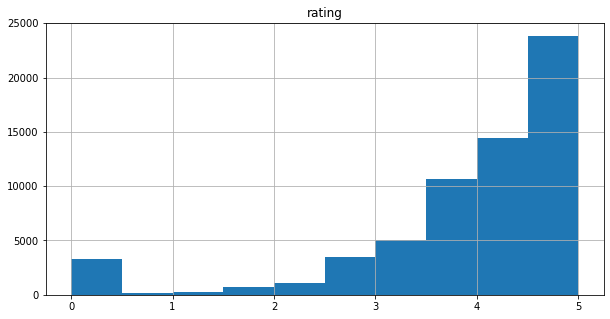

In [6]:
df_train_metadata.hist(column='rating', figsize=(10, 5))

<AxesSubplot:>

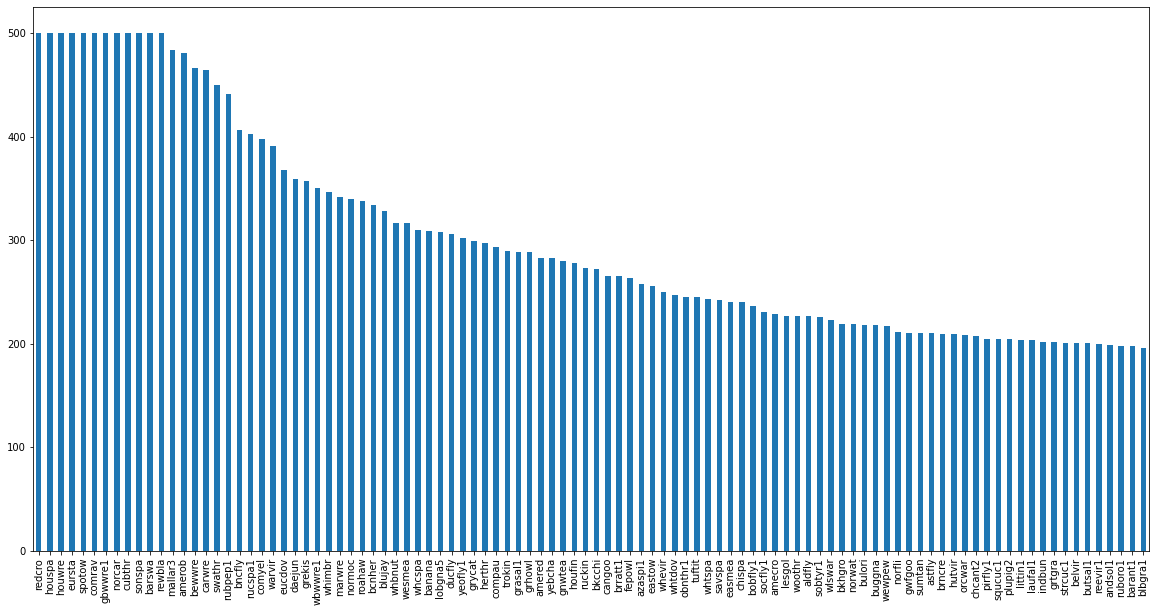

In [7]:
df_train_metadata['primary_label'].value_counts()[:100].plot(kind="bar", figsize=(20, 10), rot=90)

In [8]:
df_train_soundscape.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [9]:
def scale_minmax(x, min=0.0, max=1.0):
    x_std = (x - x.min()) / (x.max() - x.min())
    x_scaled = x_std * (max - min) + min
    return x_scaled

In [10]:
def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_mels=n_mels,                   
        n_fft=hop_length*2, 
        hop_length=hop_length
    )
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(out, img)

In [11]:
def extract_links_and_labels(data_dir):
    audio_clips = []
    folder_names = []
    file_names = []
    birds = os.listdir(data_dir)
    labels = []

    for bird in birds:
        for clip in os.listdir(data_dir + "/" + bird):
            folder_names.append(bird)
            file_names.append(clip.split(".ogg")[0])
            audio_clips.append(data_dir +  "/" + bird + "/" + clip)
            labels.append(bird)
    
    return folder_names, file_names, audio_clips, labels

In [12]:
folder_names, file_names, train_audio_clips, labels = extract_links_and_labels(train_datadir)

In [13]:
train_audio_clips = []
folder_names = []
file_names = []
birds = os.listdir(train_datadir)
labels = []

for bird in birds:
    for clip in os.listdir(train_datadir +  "/" + bird):
        folder_names.append(bird)
        file_names.append(clip.split(".ogg")[0])
        train_audio_clips.append(train_datadir +  "/" + bird + "/" + clip)
        labels.append(bird)

In [14]:
!rm -rf kaggle/working

In [15]:
!mkdir train_images

In [16]:
def extract_spectogram(path, folder_name, file_name):
    start_sample = 0 # starting at beginning
    length_samples = time_steps * hop_length
    counter = 0
    y, sr = librosa.load(path, offset=offset, duration=duration, sr=sample_rate)
    while (start_sample <= len(y) and start_sample + length_samples <= len(y)):
        # extract a fixed length window
        window = y[start_sample: start_sample + length_samples]
        # convert to PNG
        if not os.path.exists('train_images/' + folder_name):
            os.makedirs('train_images/' + folder_name)
        spectrogram_image(window, 
                          sr=sr, 
                          out='train_images/' + folder_name + "/" + file_name + "_" + str(counter) + ".png", 
                          hop_length=hop_length, 
                          n_mels=n_mels)
        start_sample = start_sample + length_samples
        counter += 1

In [17]:
extract_spectogram(train_audio_clips[0], folder_names[0], file_names[0])

In [18]:
for i in tqdm(range(len(train_audio_clips))):
    extract_spectogram(train_audio_clips[i], folder_names[i], file_names[i])

  2%|▏         | 1429/62874 [01:45<1:11:49, 14.26it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: train_images/bkmtou1/XC518213_0.png is a low contrast image
100%|██████████| 62874/62874 [1:20:16<00:00, 13.05it/s]


In [19]:
def imagetensor(imagedir):  
    for i, im in enumerate(os.listdir(imagedir)):

        image= cv2.imread(os.path.join(imagedir, im), 0)
        image.resize(32, 96)
#         image = image.resize(48,144)
#         print(image.shape)

        if i == 0:
            images= np.expand_dims(np.array(image, dtype= float) / 255, axis= 0)
        else:
            image= np.expand_dims(np.array(image, dtype= float) / 255, axis= 0)
            images= np.append(images, image, axis= 0)
    return images

In [20]:
labels = []
for label in os.listdir('./train_images/'):
    if (not '.ipynb' in label and 
        not 'h5'in label and 
        not '.npy' in label and 
        not '.txt' in label and 
        not 'out' in label):
        labels.append(label)

In [21]:
len(labels)

397

In [22]:
x_train = np.array([])
y_train = []
for idx, label in tqdm(enumerate(tqdm(labels))):
    if idx == 0:
        x_train= imagetensor('./train_images/' + label)
        y_train.extend([label] * len(x_train))
    else:
        images = imagetensor('./train_images/' + label)
        y_train.extend([label] * len(images))
        x_train = np.vstack((x_train, images))

  0%|          | 0/397 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 397/397 [04:16<00:00,  1.55it/s]
397it [04:16,  1.55it/s]


In [23]:
print(len(x_train), len(y_train))

61440 61440


In [24]:
inputs = x_train.reshape((61440, 32, 96, 1))
outputs = pd.get_dummies(pd.Series(y_train)).to_numpy()

In [25]:
print(inputs.shape)
print(outputs.shape)

(61440, 32, 96, 1)
(61440, 397)


In [26]:
np.savez_compressed('batch_reduced_32_96', x=inputs, y=outputs)

In [27]:
b = os.path.getsize("batch_reduced_32_96.npz")
print(b)

203294606


In [28]:
batch_1 = np.load('batch_reduced_32_96.npz')

In [29]:
inputs = batch_1['x']
outputs = batch_1['y']

In [30]:
# x_train, x_val, y_train, y_val = sk.train_test_split(inputs, outputs, test_size=0.2, random_state = 42)

In [31]:
# print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

In [32]:
SPEC_SHAPE = inputs[0].shape
OUTPUT_SHAPE = outputs[0].shape
SEED = 8000

In [33]:
from sklearn.utils import shuffle
inputs, outputs = shuffle(inputs, outputs)

In [34]:
# Make sure your experiments are reproducible
tf.random.set_seed(SEED)

# Build a simple model as a sequence of  convolutional blocks.
# Each block has the sequence CONV --> RELU --> BNORM --> MAXPOOL.
# Finally, perform global average pooling and add 2 dense layers.
# The last layer is our classification layer and is softmax activated.
# (Well it's a multi-label task so sigmoid might actually be a better choice)
model = tf.keras.Sequential([
    
    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), 
                           activation='relu', 
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
#     # Fourth conv block
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(128, activation='relu'),   
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(128, activation='relu'),   
    tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(OUTPUT_SHAPE[0], activation='softmax')
])
print('MODEL HAS {} PARAMETERS.'.format(model.count_params()))

MODEL HAS 99789 PARAMETERS.


In [35]:
# Compile the model and specify optimizer, loss and metric
initial_learning_rate = 0.1
decay_steps = 1.0
decay_rate = 0.5
learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate, decay_steps, decay_rate
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0015),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 94, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 94, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 47, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 45, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 45, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 22, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 20, 64)         1

In [37]:
early_stopping_monitor = EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

mcp_save = ModelCheckpoint(
    './best_model.h5', 
    save_best_only=True, 
    monitor='val_accuracy',
    verbose=1
)

In [38]:
model.fit(
    inputs, 
    outputs, 
    epochs=100,
    batch_size=256, 
    validation_split=0.2, 
    callbacks=[early_stopping_monitor, mcp_save]
)

Epoch 1/100
192/192 [==============================] - 125s 637ms/step - loss: 5.9204 - accuracy: 0.0064 - auc: 0.5282 - val_loss: 5.8023 - val_accuracy: 0.0076 - val_auc: 0.5551

Epoch 00001: val_accuracy improved from -inf to 0.00765, saving model to ./best_model.h5
Epoch 2/100
192/192 [==============================] - 124s 648ms/step - loss: 5.7878 - accuracy: 0.0106 - auc: 0.5704 - val_loss: 5.7928 - val_accuracy: 0.0098 - val_auc: 0.5606

Epoch 00002: val_accuracy improved from 0.00765 to 0.00977, saving model to ./best_model.h5
Epoch 3/100
192/192 [==============================] - 143s 748ms/step - loss: 5.7424 - accuracy: 0.0124 - auc: 0.5815 - val_loss: 5.7512 - val_accuracy: 0.0100 - val_auc: 0.5720

Epoch 00003: val_accuracy improved from 0.00977 to 0.01001, saving model to ./best_model.h5
Epoch 4/100
192/192 [==============================] - 128s 667ms/step - loss: 5.7134 - accuracy: 0.0145 - auc: 0.5884 - val_loss: 5.8186 - val_accuracy: 0.0092 - val_auc: 0.5662

Epoch 0

In [39]:
!rm rf train_soundscapes

rm: cannot remove 'rf': No such file or directory
rm: cannot remove 'train_soundscapes': No such file or directory


In [40]:
!mkdir train_soundscapes_2

In [41]:
soundscape_links = []
filenames = []
for soundscape in os.listdir(soundscapes):
    soundscape_link = soundscapes + '/' + soundscape
    soundscape_links.append(soundscape_link)
    filenames.append(soundscape.split('.')[0])

In [42]:
print(soundscape_links[0])
print(filenames[0])
output_links = []

../input/birdclef-2021/train_soundscapes/20152_SSW_20170805.ogg
20152_SSW_20170805


In [43]:
def extract_soundscape_spectogram(path, file_name):
    start_sample = 0 # starting at beginning
    length_samples = time_steps * hop_length
    y, sr = librosa.load(path, offset=offset, duration=duration, sr=sample_rate)
    counter = 5
#     output_links = []
    while (start_sample <= len(y) and start_sample + length_samples <= len(y)):
        # extract a fixed length window
        window = y[start_sample: start_sample + length_samples]
        # convert to PNG
        spectrogram_image(window, 
                          sr=sr, 
                          out='train_soundscapes_2/' + file_name + "_" + str(counter) + ".png", 
                          hop_length=hop_length, 
                          n_mels=n_mels)
        start_sample = start_sample + length_samples
        output_links.append(file_name + "_" + str(counter) + ".png")
        counter += 5

In [44]:
for i in tqdm(range(len(soundscape_links))):
    extract_soundscape_spectogram(soundscape_links[i], filenames[i])

100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


In [45]:
len(soundscape_links), len(output_links)

(20, 20)

In [46]:
output_links

['20152_SSW_20170805_5.png',
 '57610_COR_20190904_5.png',
 '7843_SSW_20170325_5.png',
 '42907_SSW_20170708_5.png',
 '7019_COR_20190904_5.png',
 '54955_SSW_20170617_5.png',
 '10534_SSW_20170429_5.png',
 '2782_SSW_20170701_5.png',
 '11254_COR_20190904_5.png',
 '7954_COR_20190923_5.png',
 '26746_COR_20191004_5.png',
 '18003_COR_20190904_5.png',
 '31928_COR_20191004_5.png',
 '51010_SSW_20170513_5.png',
 '21767_COR_20190904_5.png',
 '14473_SSW_20170701_5.png',
 '44957_COR_20190923_5.png',
 '50878_COR_20191004_5.png',
 '28933_SSW_20170408_5.png',
 '26709_SSW_20170701_5.png']

In [47]:
x_test = imagetensor('./train_soundscapes_2/')

In [48]:
x_test.shape

(20, 32, 96)

In [49]:
x_test = x_test.reshape((20, 32, 96, 1))
np.savez_compressed('test_reduced_32_96', x=x_test)

In [50]:
from tensorflow import keras
model = keras.models.load_model('./best_model.h5')

In [51]:
p = model.predict(x_test)
y_prob = np.argmax(p, axis=1)

In [52]:
submission = []
for i in range(len(p)):
    data = {}
    label = output_links[i].split('_')[0] + '_' + output_links[i].split('_')[1] + '_' + output_links[i].split('_')[-1].split('.png')[0]
    data['row_id'] = label
    if (p[i][y_prob[i]]) < threshold:
        data['birds'] = 'nocall'
    else:
        data['birds'] = labels[y_prob[i]]
    submission.append(data)

In [53]:
df_submission = pd.DataFrame(submission)
df_submission.head()

,row_id,birds
0,20152_SSW_5,grasal1
1,57610_COR_5,barswa
2,7843_SSW_5,barswa
3,42907_SSW_5,barswa
4,7019_COR_5,barswa


In [54]:
df_submission.to_csv("submission.csv", index=False)